In [74]:
import string
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from pickle import dump, load
from collections import Counter 
from keras.applications.xception import preprocess_input, Xception
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm_notebook as tqdm

In [67]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "Flickr8k_Dataset/"
## The location of the caption file
dir_Flickr_text = "Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8092


In [72]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


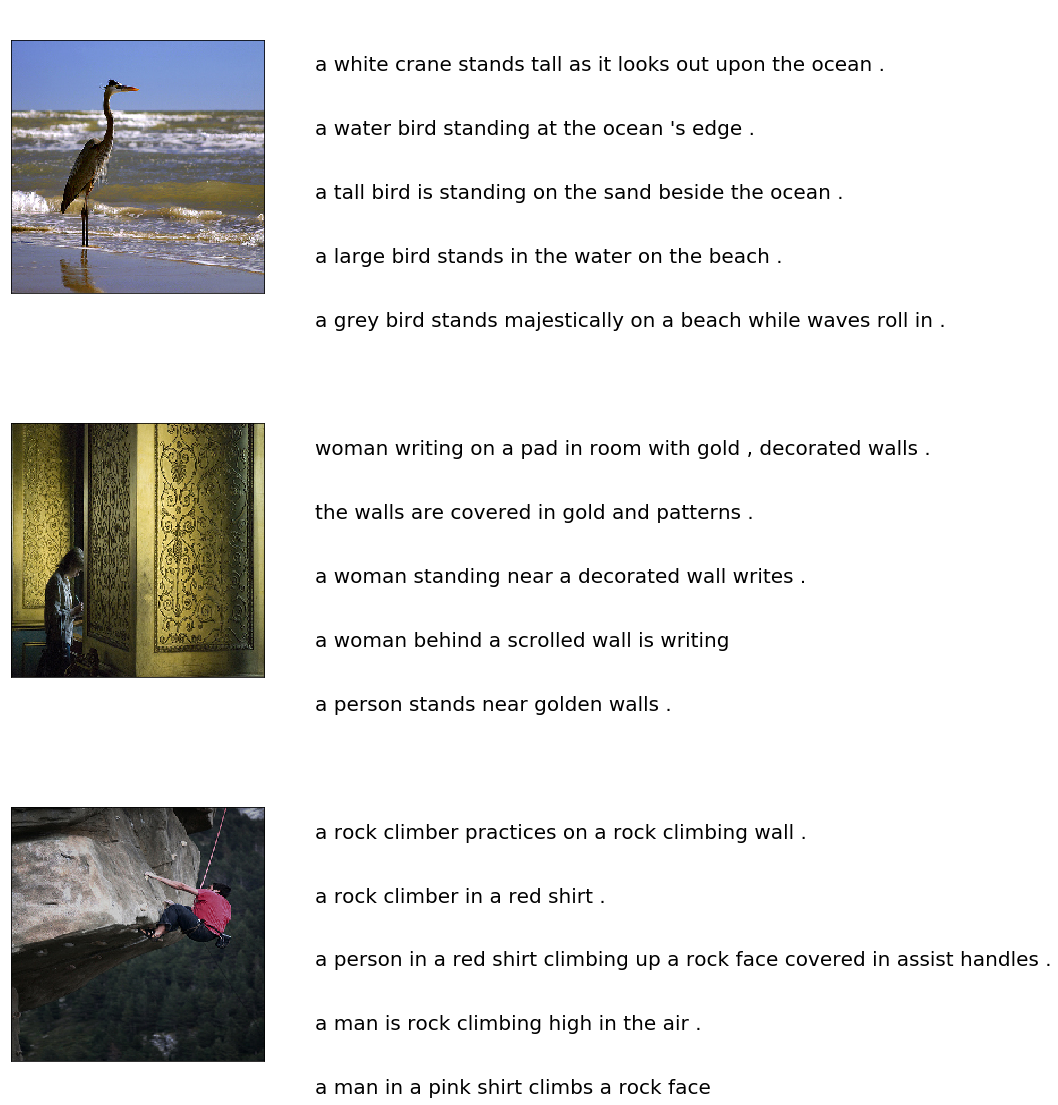

In [80]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 3 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-3:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [14]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [15]:
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for txt in captions[:-1]:
        img, caption = txt.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


file = "Flickr8k.token.txt"
descriptions = all_img_captions(file)
len(descriptions.keys())

8092

In [16]:
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption.replace("-", " ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if (len(word) > 1)]
            desc = [word for word in desc if (word.isalpha())]
            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions

In [17]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [18]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()

In [19]:
filename = "Flickr8k.token.txt"
descriptions = all_img_captions(filename)
print("Length of descriptions =", len(descriptions))
clean_descriptions = cleaning_text(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [20]:
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

word_count_threshold = 8
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Preprocessed words=%d ' % len(vocab))

Preprocessed words=2246 


In [45]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image / 127.5
        image = image - 1.0
        feature = model.predict(image)
        features[img] = feature
    return features


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [ ]:
#features = extract_features(dataset_images)
#dump(features, open("features.p", "wb"))

In [46]:
features = load(open("features.p", "rb"))

In [49]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions


def load_features(photos):
    all_features = load(open("features.p", "rb"))
    features = {k: all_features[k] for k in photos}
    return features


def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [50]:
filename = "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [51]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in tqdm(descriptions.items()):
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' %
          corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' %
          corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' %
          corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' %
          corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [52]:
test_dire = "Flickr_8k.testImages.txt"
test_imgs = load_photos(test_dire)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs)
test_tokenizer = create_tokenizer(test_descriptions)

In [53]:
max_length_test=max_length(test_descriptions)
max_length_test

30

In [54]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [55]:
max_length = max_length(descriptions)
max_length

32

In [56]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
       0.24176797], dtype=float32)

In [57]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(
                tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word


def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [58]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))

In [59]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length, ))
    se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    plot_model(model,
               to_file='./model.png',
               show_shapes=True,
               show_layer_names=True)
    return model

In [61]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

epochs = 10
steps = len(train_descriptions)
model = define_model(vocab_size, max_length)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer,max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, initial_epoch=0)
    model.save("model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      1515400     input_14[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_13[0][0]

In [89]:
steps = len(train_descriptions)
model = define_model(vocab_size, max_length)
filepath_for_model="model {epoch:02d} loss {loss:.4f} accuracy {accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath_for_model, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
# model.fit(x, y, epochs=40, batch_size=50, callbacks=callbacks_list)
generator = data_generator(train_descriptions, train_features, tokenizer,max_length)
hist = model.fit(generator, batch_size=30 ,epochs=5, steps_per_epoch=steps*2, callbacks=callbacks_list, initial_epoch=0)
model.save("final.h5")

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 32, 200)      1515400     input_22[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_21[0][0]                   
______________________________________________________________________________________

In [64]:
mod=load_model("model_9.h5")

In [65]:
evaluate_model(mod, test_descriptions, test_features, test_tokenizer, 32)

d:\python\python36\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
d:\python\python36\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.272195
BLEU-2: 0.030590
BLEU-3: 0.000000
BLEU-4: 0.000000
